<a href="https://colab.research.google.com/github/Badar97/Progetto_DataScience/blob/main/5-Bert/BERT_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-Tuning BERT for Text Classification

### Import torch e transformers

In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.9 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
#from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [6]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0


## Preprocessing data

In [75]:
#carcio il dataset
import csv
df = pd.read_csv("/content/imdb.csv", engine="python", on_bad_lines = 'warn')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [76]:
#conto gli elementi per ogni label

from collections import Counter
Counter(df.sentiment)

Counter({'positive': 25000, 'negative': 25000})

In [77]:
#mapping dei label

df['sentiment'] = df.sentiment.map({'negative':0,'positive':1})

In [78]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [79]:
## mescolo i record

def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i]) # mischio il dataframe 
    return df

new_df = shuffle(df)
new_df

,review,sentiment
36457,Come on Tina Fey you can do better then this. ...,0
48521,This is a very beautiful and almost meditative...,1
5586,What an embarassment...This doesnt do justice ...,0
40152,"To begin with, I really love Lucy. Her TV show...",0
9437,I haven't seen this film in years so my knowle...,1
...,...,...
16180,I can understand how fans of filmmaker Roman P...,1
46643,Rita Hayworth lights up the screen in this fun...,1
43178,The operative rule in the making of this film ...,0
17408,I expected this to be a lot better. I love Tim...,0


## elimino le stopwords

In [80]:
# definisco la funzione per eliminare le stopword

from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [81]:
#rimuovo le stopwords

df['review'] = df['review'].apply(lambda x: clean_text(x))

## Train Test Split

In [82]:
#divido il dataset in train e test
split_idx = round(0.80*len(df))
#split_idx = int(len(df)*0.8)
#train_set = df_monthly[:i]
train_df = df[:split_idx]
test_df = df[split_idx:]
print('train lenght:',len(train_df))
print(train_df.groupby(['sentiment'])['review'].count())
print('test lenght:',len(test_df))
print(test_df.groupby(['sentiment'])['review'].count())

train lenght: 40000
sentiment
0    20007
1    19993
Name: review, dtype: int64
test lenght: 10000
sentiment
0    4993
1    5007
Name: review, dtype: int64


In [83]:
#definisco le sentences e i label del train

sentences = train_df.review
labels = list(train_df.sentiment)

In [84]:
#definisco il tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### esempio di tokenizzazione

In [85]:
#mostro la tokenizzazione della prima riga

index=0
print(' Original: ', list(sentences)[index])

#print('Tokenized: ', tokenizer.tokenize(comms[index])) # Print the sentence split into tokens.

#print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(comms[index]))) # Print the sentence mapped to token ids.

table = np.array([tokenizer.tokenize(list(sentences)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))



 Original:  one reviewers mentioned watching oz episode hooked right, exactly happened br br first thing struck oz brutality unflinching scenes violence, set right word go trust me, show faint hearted timid show pulls punches regards drugs, sex violence hardcore, classic use word br br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city, experimental section prison cells glass fronts face inwards, privacy high agenda em city home manyaryans, muslims, gangstas, latinos, christians, italians, irish moreso scuffles, death stares, dodgy dealings shady agreements never far away br br would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences, forget charm, forget romanceoz mess around first episode ever saw struck nasty surreal, say ready it, watched more, developed taste oz, got accustomed high levels graphic violence violence, injustice crooked guards sold nickel, inmates kill order get away it, well m

### Add special tokens

In [86]:
#aggiungo token speciali

max_len = 0
l=[]
# For every sentence...
for sent in list(sentences):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512: 
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  512
Avg sentence length:  152


In [87]:
#tokenizzo ogni sentence del training

MAX_LEN = 128
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Esempio di Encoding

In [88]:
# stampo la sentence 0 come lista di id

i=random.randint(0,len(sentences)-1)
print('Original: ', list(sentences)[i])
print('Input IDs:', input_ids[i])

Original:  loved show much incredibly sad canceled thought came back too, two stupid weeks thats terrible hate never find everyone ends sucks bring back abc stupid shows like supernanny whatnot give time good ones like six degrees complaining ratings probably bad slot truly good show, something could relate anticipated jj abrams delivered, awesome, wish abc could trust enough complete story loved entire cast wait see everyone would someday meet everyone story left incomplete, never know steven whitney would get together carlos mae wanted see would happen laura damien everyone else really downer
Input IDs: tensor([  101,  3866,  2265,  2172, 11757,  6517, 13261,  2245,  2234,  2067,
         2205,  1010,  2048,  5236,  3134,  2008,  2015,  6659,  5223,  2196,
         2424,  3071,  4515, 19237,  3288,  2067,  5925,  5236,  3065,  2066,
         3565,  7229,  4890,  2054, 17048,  2507,  2051,  2204,  3924,  2066,
         2416,  5445, 17949,  8599,  2763,  2919, 10453,  5621,  2204,  226

In [89]:
#mostro i token e l'attentiont mask di una sentence random

def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(sentences) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index])
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

spike milligan one funniest men ever seen, huge influence life br br movie limp awful, memory credit script cluttered preserves many lines book intact leg jokes incomprehensible actors performances uniformly ineffective, great cast wasted, lead, sean hughes, delivers milligan belligerent hostilities plaintive whine, misses point completely br br gentle pacing killer well farce accelerate towards end goon shows often did, novel puckoon definitely did, film, anything, slows want various elements smash together final climax br br milligan narrated abridged audio recording puckoon , tp mckenna, dermot kelly, norma ronald jack hobbs now, funny ten minutes funnier whole film believe lp transferred cd, know still print br br movie adolf hitler part downfall jim dale arthur lowe godawful mess, funnier thing br br possible milligan spirit rambunctious screen reviewers indulging politeness wishful thinking film fumbles virtually every opportunity never misses chance disappoint
╒══════════════╤══

## Train Validation Split

In [90]:
#divido il training in training e validation

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

32,000 training samples
8,000 validation samples


Train parameters
The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

In [91]:
#definisco la batch size, ovvero il numero di semple che saranno propagati attraverso la rete

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Some Prediction Metrics

In [92]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

## Create BERT model

In [93]:
#creo il modello di Bert

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
    model = model.cuda()
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [94]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Fine tuning the model

In [95]:
#definisco le epochs(il nuemro di volte che usiamo i data), le total step e creo lo scheduler

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [96]:
#definisco la funzione per calcolare l'accuratezza della predizione vs i label veri

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [97]:
#definisco la funzione per mostrare il tempo nel formato hh:mm:ss

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [98]:
#faccio training e validation

epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
print("Training complete!")

#print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Epoch:  25%|██▌       | 1/4 [12:40<38:01, 760.36s/it]


	 - Train loss: 0.3367
	 - Validation Accuracy: 0.8881
	 - Validation Precision: 0.8639
	 - Validation Recall: 0.9261
	 - Validation Specificity: 0.8537



Epoch:  50%|█████     | 2/4 [25:24<25:25, 762.81s/it]


	 - Train loss: 0.1943
	 - Validation Accuracy: 0.8950
	 - Validation Precision: 0.8884
	 - Validation Recall: 0.9075
	 - Validation Specificity: 0.8860



Epoch:  75%|███████▌  | 3/4 [38:09<12:43, 763.53s/it]


	 - Train loss: 0.0959
	 - Validation Accuracy: 0.8918
	 - Validation Precision: 0.8903
	 - Validation Recall: 0.8967
	 - Validation Specificity: 0.8882



Epoch: 100%|██████████| 4/4 [50:53<00:00, 763.48s/it]


	 - Train loss: 0.0536
	 - Validation Accuracy: 0.8891
	 - Validation Precision: 0.8562
	 - Validation Recall: 0.9385
	 - Validation Specificity: 0.8436

Training complete!


## Training stats

In [ ]:
#calcolo le statistiche di training

import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 5)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.380019,0.303208,0.876845,0:06:27,0:00:33
2,0.208087,0.401484,0.874539,0:06:31,0:00:33
3,0.108730,0.498803,0.887454,0:06:31,0:00:33
4,0.055709,0.552910,0.887685,0:06:32,0:00:33


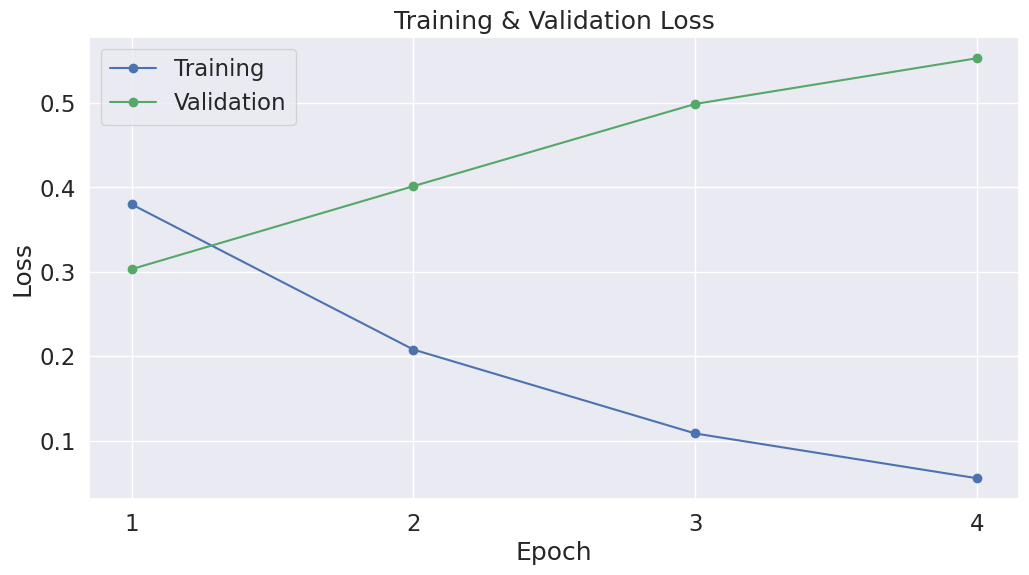

In [ ]:
#creo il grafico per mostrale il loss tra test e validation in base alle epoch

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

An **underfit** model can be identified from the learning curve of the training loss only.

It may show a flat line or noisy values of relatively high loss, indicating that the model was unable to learn the training dataset at all.

An example of this is provided below and is common when the model does not have a suitable capacity for the complexity of the dataset.

A plot of learning curves shows **underfitting** if:

- The training loss remains flat regardless of training.
- The training loss continues to decrease until the end of training.

A plot of learning curves shows **overfitting** if:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.

A plot of learning curves shows a **good** fit if:

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

## Loading the best model

In [99]:
model = torch.load('bert_model_bbc')

FileNotFoundError: ignored

## Test performance

In [100]:
#tokenizzo il test set

# Create sentence and label lists
sentences = test_df.review
labels = list(test_df.sentiment)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [101]:
#faccio la predizione del test set

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [102]:
#calcolo l'accuracy delle predizioni

from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.8874

### Confusion Matrix

In [103]:
#calcolo l matrice di confusione

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

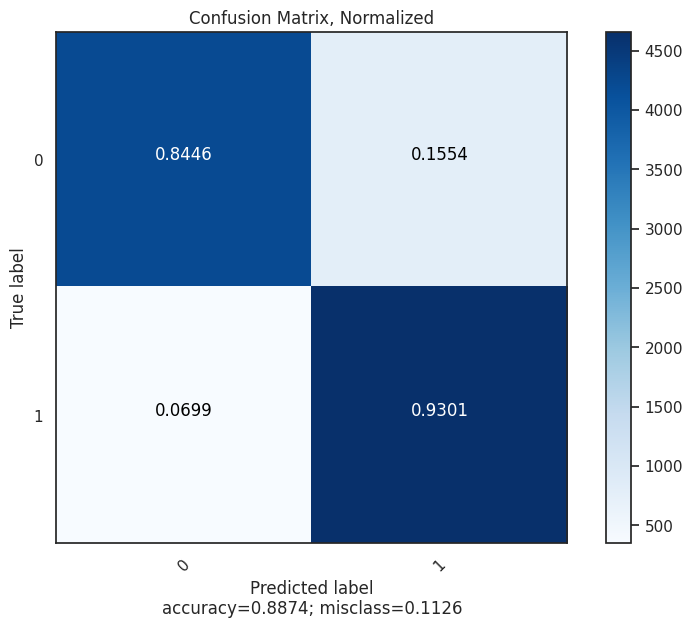

In [107]:
#la visualizzo
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      target_names = ['0', '1'],
                      normalize    = True,
                      title        = "Confusion Matrix, Normalized")